In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/raw/creditcard.csv')

### All Transformation

In [3]:
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    QuantileTransformer
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA


default_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)

Time_rbf_transformer = FunctionTransformer(
    rbf_kernel,
    feature_names_out='one-to-one',
    kw_args={
        'Y':[[79000]],
        'gamma':1e-8
    }
)

q_heavy_tail_pipeline = make_pipeline(
    QuantileTransformer(output_distribution='normal'),
    StandardScaler()
)

# V2, V5, V7 with Amount
V2_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

V5_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

V7_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)


all_transformation = ColumnTransformer(
    transformers=[
        ('Time_rbf', Time_rbf_transformer, ['Time']),
        ('heavy_tail', q_heavy_tail_pipeline, ['V1', 'V2', 'V3', 'V4', 'V5',
                                               'V6','V7', 'V8', 'V9', 'V10',
                                               'V11', 'V12', 'V14', 'V15',
                                               'V16', 'V17', 'V18', 'V19', 'V20',
                                               'V21', 'V22', 'V23', 'V24', 'V25',
                                               'V27', 'V28', 'Amount']),
        ('V2_amount', V2_amount_pipeline, ['V2', 'Amount']),
        ('V5_amount', V5_amount_pipeline, ['V5', 'Amount']),
        ('V7_amount', V7_amount_pipeline, ['V7', 'Amount'])
        
    ],
    remainder=default_pipeline,
    force_int_remainder_cols=False
)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(df,
                               test_size=0.2,
                               stratify=df['Class'],
                               random_state=10
                               )

In [6]:
X_train, X_test = train.drop('Class', axis=1), test.drop('Class', axis=1)
y_train, y_test = train['Class'], test['Class']

## LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [9]:
lr_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('logistic_r', LogisticRegression(
            random_state=10,
            max_iter=1000,
            n_jobs=-1)
    )
])

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                               'gamma': 1e-8}], # this gamma is optimized
        'logistic_r__solver': ['saga'],
        'logistic_r__penalty': ['l1', 'l2']
    },
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                               'gamma': 1e-8}],
        'logistic_r__solver': ['sag'],
        'logistic_r__penalty': ['l2']
    },
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],  
                                               'gamma': 1e-8}],
        'logistic_r__solver': ['saga'],
        'logistic_r__penalty': ['elasticnet'],
        'logistic_r__l1_ratio': [0.3, 0.5, 0.8]
    }
]

In [11]:
lr_gs = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

In [12]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformation',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('Time_rbf',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function rbf_kernel at 0x00000121C4BF6D40>,
                                                                                             k...
                                                                 'gamma': 1e-08}]},
                         {'logistic_r__penalty': ['l2'],
                          'logistic_r__solver': ['sag'],
                          'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                                                 'gamma': 1e-08}]},
                         {'logistic_r__l1_ratio': [0.3, 0.5, 0.8],
                          'logistic_r__penalty': ['elasticnet'],
                          'logistic_r__solver': ['saga'],
                          'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                                                 'gamma': 1e-08}]}],
             scoring='neg_mean_absolute_error')

In [13]:
lr_gs.best_params_

{'logistic_r__penalty': 'l1',
 'logistic_r__solver': 'saga',
 'transformation__Time_rbf__kw_args': {'Y': [[79000]], 'gamma': 1e-08}}

In [14]:
MAE_lr = -lr_gs.best_score_
MAE_lr

0.030402247141697203

In [15]:
lr_gs.best_estimator_

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x00000121C4BF6D40>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('logistic_r',
                 LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1',
                                    random_state=10, solver='saga'))])

In [16]:
pd.DataFrame(lr_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_r__penalty,param_logistic_r__solver,param_transformation__Time_rbf__kw_args,param_logistic_r__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,176.653901,44.225921,0.490618,0.061734,l1,saga,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l1', 'logistic_r__sol...",-0.030415,-0.027102,-0.032961,-0.031140,-0.030393,-0.030402,0.001897,1
2,87.344543,19.837731,0.461430,0.012868,l2,sag,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l2', 'logistic_r__sol...",-0.030525,-0.026992,-0.033202,-0.031227,-0.030240,-0.030437,0.002009,2
4,169.654976,35.726559,0.363683,0.049132,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.5,"{'logistic_r__l1_ratio': 0.5, 'logistic_r__pen...",-0.030657,-0.027058,-0.033049,-0.031249,-0.030635,-0.030530,0.001947,3
5,142.365294,30.016371,0.318751,0.072318,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.8,"{'logistic_r__l1_ratio': 0.8, 'logistic_r__pen...",-0.030547,-0.027146,-0.032588,-0.031688,-0.030788,-0.030551,0.001849,4
3,174.275102,46.837636,0.443610,0.032420,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.3,"{'logistic_r__l1_ratio': 0.3, 'logistic_r__pen...",-0.030854,-0.027233,-0.033071,-0.031293,-0.030328,-0.030556,0.001900,5
1,159.090479,35.829444,0.491422,0.041138,l2,saga,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l2', 'logistic_r__sol...",-0.030810,-0.027299,-0.033093,-0.031403,-0.030481,-0.030617,0.001887,6


In [17]:
# fitting params into model
lr_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('logistic_r', LogisticRegression(
            penalty='elasticnet', # elasticnet showed better performance in terms of runtime
            l1_ratio=0.8,
            solver='saga',
            random_state=10,
            max_iter=1000,
            n_jobs=-1)
    )
])

## Evaluation for LogisticRegression

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [19]:
y_scores_lr = cross_val_predict(
    lr_pipeline,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1
)

In [20]:
y_scores_lr.shape

(227845,)

In [21]:
# y_scores_fraud_lr = y_scores_lr[:, 1]  # probability of being a fraud

# if probability is over 0.5 return 1, else return 0
y_pred_lr = (y_scores_lr > 0.5).astype(int)

In [22]:
precision_score(y_train, y_pred_lr)

0.07305095150399017

In [23]:
recall_score(y_train, y_pred_lr)

0.9060913705583756

In [24]:
f1_score(y_train, y_pred_lr)

0.13520166635106987

In [25]:
from sklearn.metrics import precision_recall_curve

In [26]:
precision, recall, thresholds = precision_recall_curve(y_true=y_train, y_score=y_scores_lr)

In [27]:
thresholds.shape

(227153,)

In [28]:
recall.shape

(227154,)

In [29]:
precision.shape

(227154,)

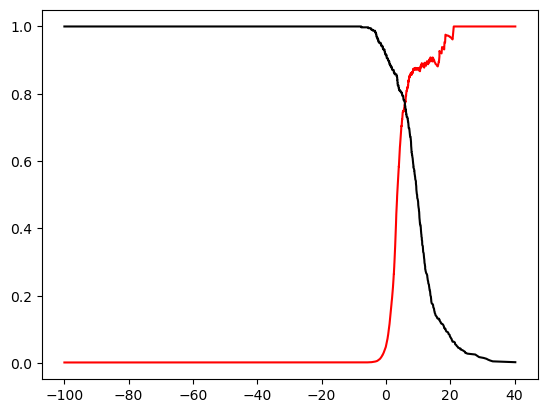

In [30]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
plt.show()

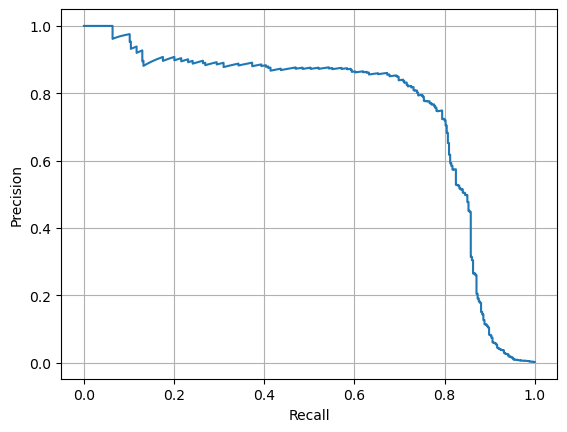

In [31]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

In [32]:
# set threshold based on recall and precision

In [33]:
threshold_75_precision = thresholds[(precision >= 0.75).argmax()]

In [34]:
threshold_75_precision

5.520904205194008

In [35]:
y_pred_75_precision = (y_scores_lr >= threshold_75_precision)

In [36]:
y_pred_75_precision

array([False, False, False, ..., False, False, False])

In [37]:
precision_score(y_train, y_pred_75_precision)

0.751219512195122

In [38]:
recall_score(y_train, y_pred_75_precision)

0.7817258883248731

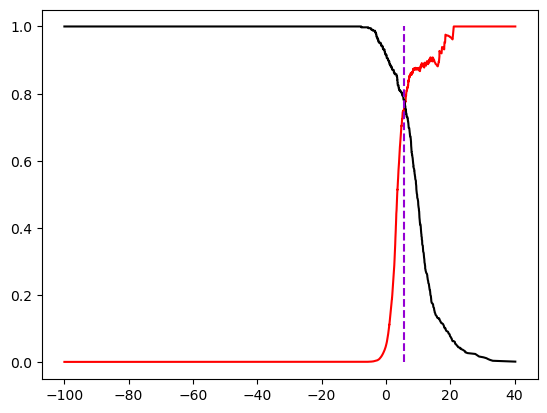

In [39]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')

ax.plot([threshold_75_precision, threshold_75_precision], [0,1], color='darkviolet', ls='--')
plt.show()

In [40]:
from sklearn.metrics import roc_curve

In [41]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_lr)

Text(0, 0.5, 'TP Ratio')

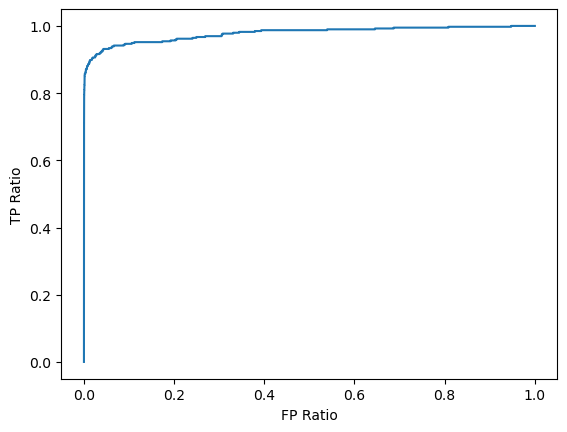

In [42]:
plt.plot(fpr, tpr)
plt.xlabel("FP Ratio")
plt.ylabel("TP Ratio")

In [43]:
# roc_auc_score lr

In [44]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores_lr)

0.9777852638177417

## LGBMClassifier

In [45]:
# !pip install lightgbm

In [46]:
import lightgbm
lightgbm.__version__

'4.6.0'

SMOTE

In [47]:
# !pip install imbalanced-learn

In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# smote = SMOTE(random_state=10)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [49]:
from lightgbm import LGBMClassifier

In [50]:
lgbm_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('lgbm', LGBMClassifier(
        random_state=10,
        n_jobs=-1,
        # verbose=-1,
    ))
])


In [51]:
lgbm_param_grid = [
    {
        'lgbm__boosting_type':['gbdt'],
        'lgbm__learning_rate':[0.05, 0.1, 0.2],
        'lgbm__num_leaves': [60, 70, 75],
        'lgbm__subsample':[0.5, 0.7, 1],   # subsample should be <= 1
        'lgbm__data_sample_strategy':['goss']
    },
]

In [52]:
lgbm_gs = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=lgbm_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

In [53]:
lgbm_gs.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformation',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('Time_rbf',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function rbf_kernel at 0...
                                                                                          PCA(n_components=2))]),
                                                                         ['V7',
                                                                          'Amount'])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('lgbm',
                                        LGBMClassifier(n_jobs=-1,
                                                       random_state=10))]),
             n_jobs=-1,
             param_grid=[{'lgbm__boosting_type': ['gbdt'],
                          'lgbm__data_sample_strategy': ['goss'],
                          'lgbm__learning_rate': [0.05, 0.1, 0.2],
                          'lgbm__num_leaves': [60, 70, 75],
                          'lgbm__subsample': [0.5, 0.7, 1]}],
             scoring='neg_mean_absolute_error')

In [54]:
lgbm_gs.best_params_

{'lgbm__boosting_type': 'gbdt',
 'lgbm__data_sample_strategy': 'goss',
 'lgbm__learning_rate': 0.2,
 'lgbm__num_leaves': 70,
 'lgbm__subsample': 0.5}

In [55]:
MAE_lgbm = -lgbm_gs.best_score_
MAE_lgbm

0.0004915622462639075

In [56]:
lgbm_gs.best_estimator_

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x00000121C4BF6D40>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('lgbm',
                 LGBMClassifier(data_sample_strategy='goss', learning_rate=0.2,
                                n_jobs=-1, num_leaves=70, random_state=10,
                                subsample=0.5))])

In [57]:
lgbm_gs.n_splits_

5

In [58]:
pd.DataFrame(lgbm_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__boosting_type,param_lgbm__data_sample_strategy,param_lgbm__learning_rate,param_lgbm__num_leaves,param_lgbm__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,67.698615,3.647196,1.102717,0.079132,gbdt,goss,0.2,70,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000527,-0.000505,-0.000351,-0.000593,-0.000483,-0.000492,0.000079,1
23,65.901595,4.980720,1.082110,0.051347,gbdt,goss,0.2,70,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000439,-0.000549,-0.000461,-0.000571,-0.000439,-0.000492,0.000057,2
18,64.330311,6.736627,1.092074,0.060541,gbdt,goss,0.2,60,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000549,-0.000527,-0.000373,-0.000483,-0.000571,-0.000500,0.000070,3
25,51.857346,3.075820,0.811706,0.113082,gbdt,goss,0.2,75,0.7,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000527,-0.000593,-0.000417,-0.000483,-0.000505,-0.000505,0.000057,4
20,55.799335,4.517788,1.041198,0.082408,gbdt,goss,0.2,60,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000527,-0.000527,-0.000417,-0.000571,-0.000505,-0.000509,0.000051,5
26,39.785404,4.468866,0.643296,0.146629,gbdt,goss,0.2,75,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000571,-0.000636,-0.000461,-0.000505,-0.000483,-0.000531,0.000064,6
19,54.099350,3.256509,1.316398,0.632823,gbdt,goss,0.2,60,0.7,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000571,-0.000571,-0.000439,-0.000593,-0.000527,-0.000540,0.000055,7
17,59.679179,1.335921,0.995729,0.048864,gbdt,goss,0.1,75,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000571,-0.000593,-0.000549,-0.000636,-0.000549,-0.000579,0.000033,8
12,60.565826,3.234688,1.089414,0.091804,gbdt,goss,0.1,70,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000549,-0.000658,-0.000614,-0.000614,-0.000549,-0.000597,0.000043,9
15,64.084409,4.744585,1.015623,0.097860,gbdt,goss,0.1,75,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000680,-0.000636,-0.000549,-0.000614,-0.000593,-0.000614,0.000044,10


### Evaluation for LGBM

In [59]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

In [60]:
lgbm_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('lgbm', LGBMClassifier(
        boosting_type='gbdt',
        learning_rate=0.2,
        num_leaves=70,
        subsample=0.5,
        data_sample_strategy='goss',
        random_state=10,
        n_jobs=-1,
        force_col_wise=True,
        verbose=-1
    ))
])

In [61]:
y_scores_lgbm = cross_val_predict(
    lgbm_pipeline,
    X_train,
    y_train,
    cv=5,
    method='predict_proba',
    n_jobs=-1
)

In [62]:
y_scores_lgbm

array([[9.99999771e-01, 2.28622566e-07],
       [9.99999984e-01, 1.63024570e-08],
       [9.99999963e-01, 3.68208560e-08],
       ...,
       [9.99999807e-01, 1.93308378e-07],
       [9.99999966e-01, 3.36663219e-08],
       [9.99999628e-01, 3.71593735e-07]])

In [63]:
y_scores_lgbm_fraud = y_scores_lgbm[:, 1]  # probability of being a fraud
y_scores_lgbm_fraud

array([2.28622566e-07, 1.63024570e-08, 3.68208560e-08, ...,
       1.93308378e-07, 3.36663219e-08, 3.71593735e-07])

In [64]:
from sklearn.metrics import precision_recall_curve

In [65]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_train,
    y_score=y_scores_lgbm_fraud,
)

In [66]:
precision.shape

(225524,)

In [67]:
recall.shape

(225524,)

In [68]:
thresholds.shape

(225523,)

In [69]:
thresholds.max()

0.9999999940173145

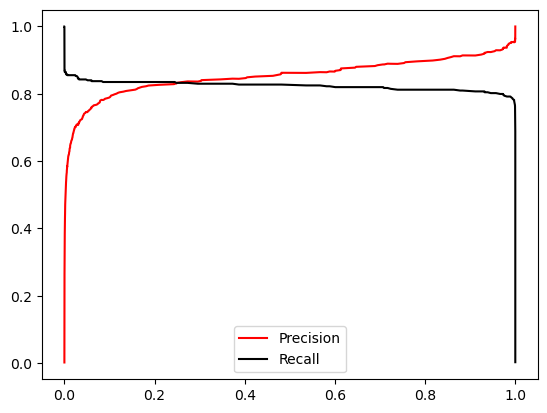

In [70]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], color='r', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
ax.legend()
plt.show()

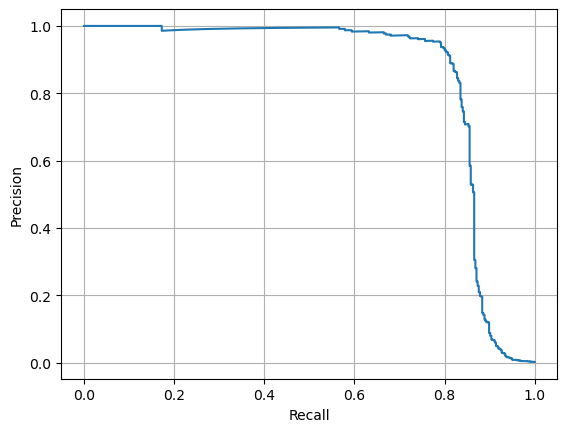

In [71]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [72]:
# changing threshold

In [73]:
threshold_90_precision = thresholds[(precision >= 0.90).argmax()]
threshold_90_precision

0.8332801889358494

In [74]:
y_pred_90_precision = (y_scores_lgbm_fraud >= threshold_90_precision)
y_pred_90_precision

array([False, False, False, ..., False, False, False])

In [75]:
precision_score(y_train, y_pred_90_precision)

0.9014084507042254

In [76]:
recall_score(y_train, y_pred_90_precision)

0.8121827411167513

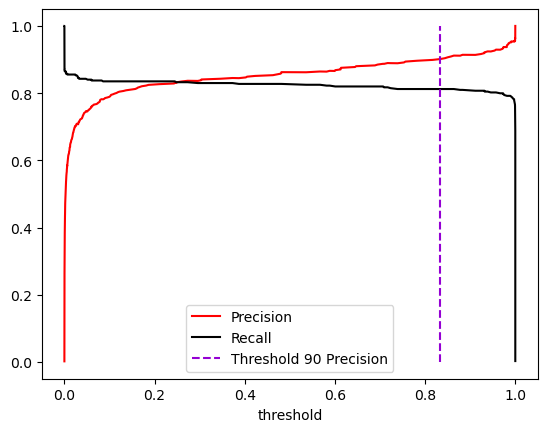

In [77]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
plt.xlabel('threshold')
ax.plot([threshold_90_precision, threshold_90_precision], [0,1],
        color='darkviolet', ls='--', label='Threshold 90 Precision')
ax.legend()
plt.show()

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score

**F1 score**

In [79]:
# if probability is over 0.5 return 1, else return 0
y_pred = (y_scores_lgbm[:, 1] > 0.5).astype(int)

In [80]:
precision_score(y_train, y_pred)

0.8620689655172413

In [81]:
recall_score(y_train, y_pred)

0.8248730964467005

In [82]:
f1_score(y_train, y_pred)

0.8430609597924773

**ROC Curve**

In [83]:
from sklearn.metrics import roc_curve

In [84]:
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_scores_lgbm_fraud)

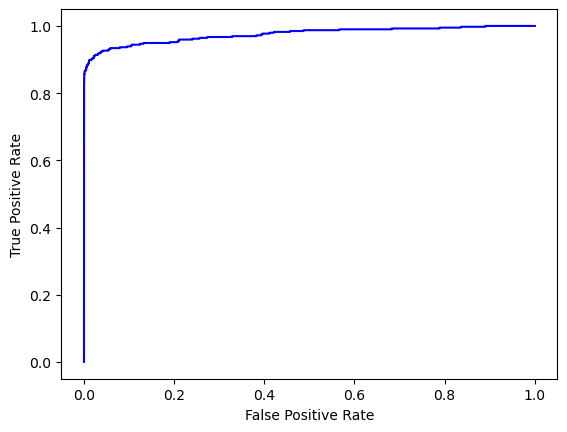

In [85]:
plt.plot(fpr, tpr, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# working on test dataset

### LGBM

In [86]:
# Train Model with SMOTE
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x00000121C4BF6D40>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('lgbm',
                 LGBMClassifier(data_sample_strategy='goss',
                                force_col_wise=True, learning_rate=0.2,
                                n_jobs=-1, num_leaves=70, random_state=10,
                                subsample=0.5, verbose=-1))])

In [87]:
from sklearn.pipeline import Pipeline
# LGBM
fitted_transformation_lgbm = lgbm_pipeline.named_steps['transformation']
fitted_lgbm = lgbm_pipeline.named_steps['lgbm']

# Trained model in a pipeline without SMOTE
lgbm_predict_pipeline = Pipeline([
    ('transformation', fitted_transformation_lgbm),
    ('lgbm', fitted_lgbm)
])



In [88]:
test_predit_lgbm = lgbm_predict_pipeline.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [89]:
# f1 score on test data with LGBM

In [90]:
f1_score(y_test, test_predit_lgbm)

0.8333333333333334

In [91]:
y_score_lgbm = lgbm_predict_pipeline.predict_proba(X_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [92]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_lgbm)

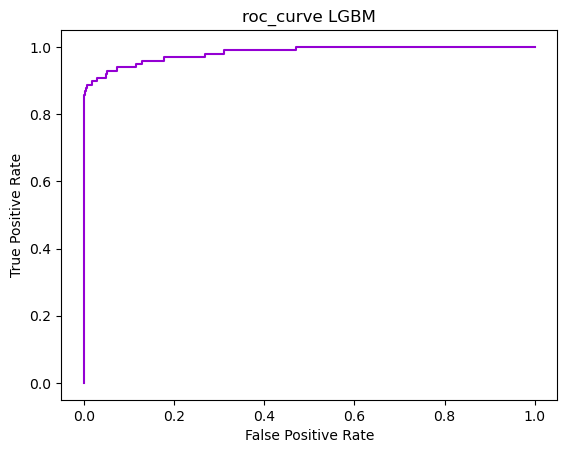

In [93]:
plt.plot(fpr, tpr, color='darkviolet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_curve LGBM')
plt.show()

### roc_auc_score

In [94]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_score_lgbm)
auc

0.9825742480447441

In [95]:
y_score_lgbm = lgbm_predict_pipeline.predict_proba(X_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [96]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_test,
    y_score=y_score_lgbm,
)

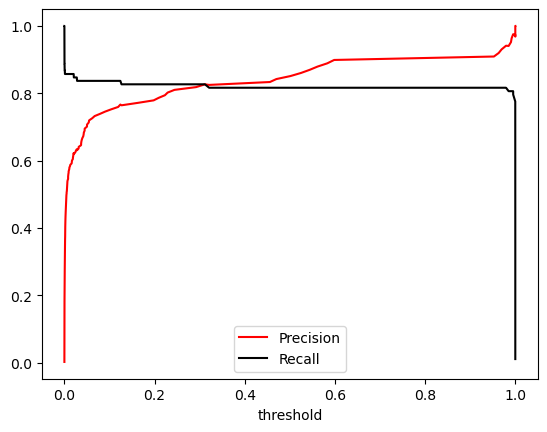

In [97]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
plt.xlabel('threshold')
ax.legend()

plt.show()

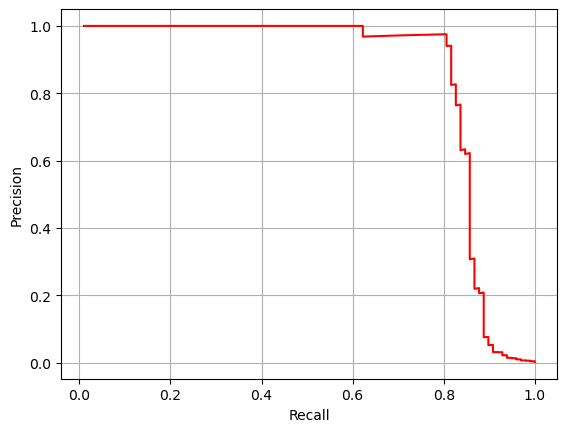

In [98]:
fig, ax = plt.subplots()
ax.plot(recall[:-1], precision[:-1], color='red',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

plt.show()

### Logistic Regression

In [99]:
# Train Model with SMOTE
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x00000121C4BF6D40>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('logistic_r',
                 LogisticRegression(l1_ratio=0.8, max_iter=1000, n_jobs=-1,
                                    penalty='elasticnet', random_state=10,
                                    solver='saga'))])

In [100]:
from sklearn.pipeline import Pipeline
# LR
fitted_transformation_lr = lr_pipeline.named_steps['transformation']
fitted_lr = lr_pipeline.named_steps['logistic_r']

# Trained model in a pipeline without SMOTE
lr_predict_pipeline = Pipeline([
    ('transformation', fitted_transformation_lr),
    ('logistic_r', fitted_lr)
])


In [101]:
test_predict_lr = lr_predict_pipeline.predict(X_test)

In [102]:
# f1 score

In [103]:
f1_score(y_test, test_predict_lr)

0.09528851244044469

In [104]:
y_score_lr = lr_predict_pipeline.decision_function(X_test)

In [105]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_lr)

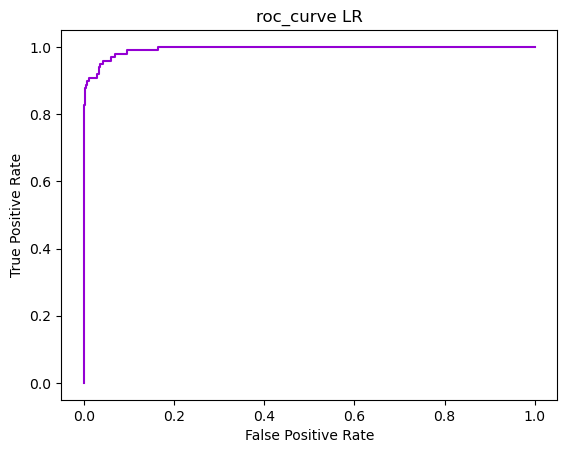

In [106]:
plt.plot(fpr, tpr, color='darkviolet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_curve LR')
plt.show()

### roc_auc_score

In [107]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_score_lr)
auc

0.9937656477897856

In [108]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_test,
    y_score=y_score_lr,
)

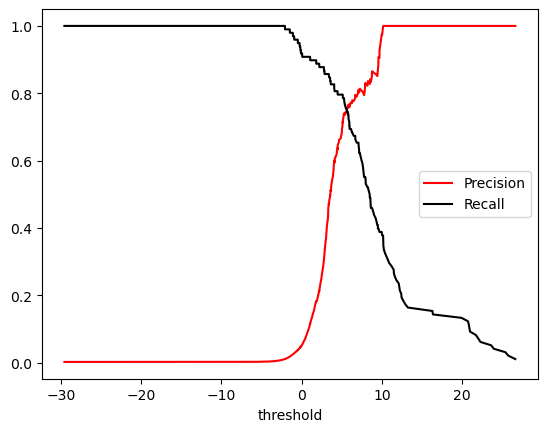

In [109]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
plt.xlabel('threshold')
ax.legend()

plt.show()

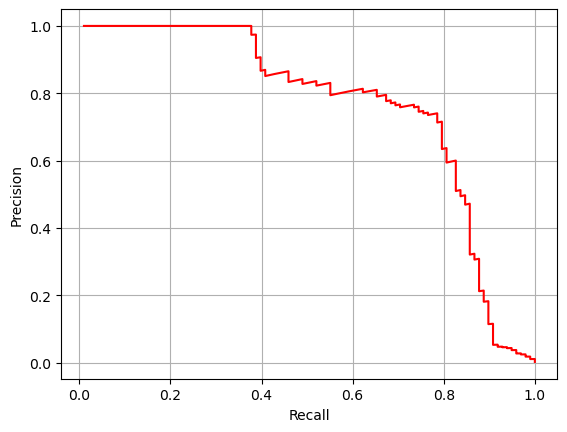

In [110]:
fig, ax = plt.subplots()
ax.plot(recall[:-1], precision[:-1], color='red',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

plt.show()

# Comparison

In [111]:
# test

In [112]:
data_test = {
    'Model':['Logistic Regression', 'LGBM'],
    'Precision_Score':[precision_score(y_test, test_predict_lr), precision_score(y_test, test_predit_lgbm)],
    'Recall_Score':[recall_score(y_test, test_predict_lr), precision_score(y_test, test_predit_lgbm)],
    'F1_Score':[f1_score(y_test, test_predict_lr), f1_score(y_test, test_predit_lgbm)],
    'roc_auc_score':[roc_auc_score(y_test, y_score_lr), roc_auc_score(y_test, y_score_lgbm)],
}

In [113]:
diff_test = pd.DataFrame(data_test)
diff_test

,Model,Precision_Score,Recall_Score,F1_Score,roc_auc_score
0,Logistic Regression,0.050251,0.918367,0.095289,0.993766
1,LGBM,0.851064,0.851064,0.833333,0.982574


In [114]:
# train

In [115]:
data_train = {
    'Model':['Logistic Regression', 'LGBM'],
    'Precision_Score':[precision_score(y_train, y_pred_lr), precision_score(y_train, y_pred)],
    'Recall_Score':[recall_score(y_train, y_pred_lr), precision_score(y_train, y_pred)],
    'F1_Score':[f1_score(y_train, y_pred_lr), f1_score(y_train, y_pred)],
    'roc_auc_score':[roc_auc_score(y_train, y_scores_lr), roc_auc_score(y_train, y_scores_lgbm_fraud)],
}

In [116]:
diff_train = pd.DataFrame(data_train)
diff_train

,Model,Precision_Score,Recall_Score,F1_Score,roc_auc_score
0,Logistic Regression,0.073051,0.906091,0.135202,0.977785
1,LGBM,0.862069,0.862069,0.843061,0.974977


In [117]:
# optimized threshold on train

In [118]:
data_opt_train = {
    'Model':['Logistic Regression', 'LGBM'],
    'Precision_Score':[precision_score(y_train, y_pred_75_precision), precision_score(y_train, y_pred_90_precision)],
    'Recall_Score':[recall_score(y_train, y_pred_75_precision), precision_score(y_train, y_pred_90_precision)],
    'F1_Score':[f1_score(y_train, y_pred_75_precision), f1_score(y_train, y_pred_90_precision)],
}

In [119]:
diff_opt = pd.DataFrame(data_opt_train)
diff_opt.set_index('Model', inplace=True)
diff_opt

,Precision_Score,Recall_Score,F1_Score
Model,,,
Logistic Regression,0.751220,0.781726,0.766169
LGBM,0.901408,0.901408,0.854473


Optimum Treshold is better, because there is a balance in precision and recall

In [120]:
total_mean = (diff_train.iloc[:, 1:] + (diff_test.iloc[:, 1:])) / 2
total_mean['Model'] = ['Logistic Regression', 'LGBM']
total_mean.set_index('Model', inplace=True)
total_mean

,Precision_Score,Recall_Score,F1_Score,roc_auc_score
Model,,,,
Logistic Regression,0.061651,0.912229,0.115245,0.985775
LGBM,0.856566,0.856566,0.838197,0.978776


### Mean Absolute Error

In [121]:
MAE_lr # Logistic Regression

0.030402247141697203

In [122]:
MAE_lgbm # LGBM

0.0004915622462639075